In [1]:
import sys
import torch
import gym
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [2]:
# Constants
GAMMA = 0.9


class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(PolicyNetwork, self).__init__()
        self.num_actions = num_actions
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.softmax(self.linear2(x), dim=1)
        return x

    def get_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(Variable(state))
        highest_prob_action = np.random.choice(self.num_actions, p=np.squeeze(probs.detach().numpy()))
        log_prob = torch.log(probs.squeeze(0)[highest_prob_action])
        return highest_prob_action, log_prob

In [3]:
def update_policy(policy_network, rewards, log_probs):
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0
        pw = 0
        for r in rewards[t:]:
            Gt = Gt + GAMMA ** pw * r
            pw = pw + 1
        discounted_rewards.append(Gt)

    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (
                discounted_rewards.std() + 1e-9)  # normalize discounted rewards

    policy_gradient = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradient.append(-log_prob * Gt)

    policy_network.optimizer.zero_grad()
    policy_gradient = torch.stack(policy_gradient).sum()
    policy_gradient.backward()
    policy_network.optimizer.step()


In [4]:
def main():
    env = gym.make('CartPole-v0')
    policy_net = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, 128)

    max_episode_num = 200
    max_steps = 10000
    numsteps = []
    avg_numsteps = []
    all_rewards = []

    for episode in range(max_episode_num):
        state = env.reset()
        log_probs = []
        rewards = []

        for steps in range(max_steps):
            env.render()
            action, log_prob = policy_net.get_action(state)
            new_state, reward, done, _ = env.step(action)
            log_probs.append(log_prob)
            rewards.append(reward)

            if done:
                update_policy(policy_net, rewards, log_probs)
                numsteps.append(steps)
                avg_numsteps.append(np.mean(numsteps[-10:]))
                all_rewards.append(np.sum(rewards))
                if episode % 1 == 0:
                    sys.stdout.write("episode: {}, total reward: {}, average_reward: {}, length: {}\n".format(episode,
                        np.round(np.sum(rewards), decimals=3),  np.round(np.mean(all_rewards[-10:]), decimals=3), steps))
                break

            state = new_state

    plt.plot(numsteps)
    plt.plot(avg_numsteps)
    plt.xlabel('Episode')
    plt.show()

episode: 0, total reward: 10.0, average_reward: 10.0, length: 9
episode: 1, total reward: 46.0, average_reward: 28.0, length: 45
episode: 2, total reward: 18.0, average_reward: 24.667, length: 17
episode: 3, total reward: 19.0, average_reward: 23.25, length: 18
episode: 4, total reward: 14.0, average_reward: 21.4, length: 13
episode: 5, total reward: 10.0, average_reward: 19.5, length: 9
episode: 6, total reward: 14.0, average_reward: 18.714, length: 13
episode: 7, total reward: 15.0, average_reward: 18.25, length: 14
episode: 8, total reward: 10.0, average_reward: 17.333, length: 9
episode: 9, total reward: 19.0, average_reward: 17.5, length: 18
episode: 10, total reward: 13.0, average_reward: 17.8, length: 12
episode: 11, total reward: 19.0, average_reward: 15.1, length: 18
episode: 12, total reward: 14.0, average_reward: 14.7, length: 13
episode: 13, total reward: 12.0, average_reward: 14.0, length: 11
episode: 14, total reward: 27.0, average_reward: 15.3, length: 26
episode: 15, to

episode: 124, total reward: 40.0, average_reward: 29.0, length: 39
episode: 125, total reward: 45.0, average_reward: 26.5, length: 44
episode: 126, total reward: 31.0, average_reward: 26.0, length: 30
episode: 127, total reward: 15.0, average_reward: 26.3, length: 14
episode: 128, total reward: 19.0, average_reward: 25.6, length: 18
episode: 129, total reward: 43.0, average_reward: 27.5, length: 42
episode: 130, total reward: 24.0, average_reward: 28.1, length: 23
episode: 131, total reward: 18.0, average_reward: 28.7, length: 17
episode: 132, total reward: 22.0, average_reward: 28.7, length: 21
episode: 133, total reward: 30.0, average_reward: 28.7, length: 29
episode: 134, total reward: 27.0, average_reward: 27.4, length: 26
episode: 135, total reward: 14.0, average_reward: 24.3, length: 13
episode: 136, total reward: 39.0, average_reward: 25.1, length: 38
episode: 137, total reward: 17.0, average_reward: 25.3, length: 16
episode: 138, total reward: 33.0, average_reward: 26.7, length

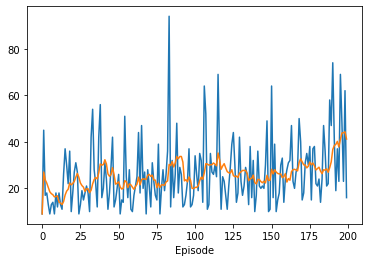

In [5]:
main()